In [164]:
#!pip install duckdb duckdb-engine
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')


# Задание таблиц БД
users = pd.read_csv('users.csv')
course_users = pd.read_csv('course_users.csv')
courses = pd.read_csv('courses.csv')
course_types = pd.read_csv('course_types.csv')
lessons = pd.read_csv('lessons.csv')
subjects = pd.read_csv('subjects.csv')
cities = pd.read_csv('cities.csv')
homework_done = pd.read_csv('homework_done.csv')
homework = pd.read_csv('homework.csv')
homework_lessons = pd.read_csv('homework_lessons.csv')
user_roles = pd.read_csv('user_roles.csv') 

In [165]:
query = """
SELECT
  -- ID курса
  cours.id AS course_id,
  -- Название курса
  cours.name AS course_name,
  -- Предмет
  sub.name AS subject,
  -- Тип предмета
  sub.project AS subject_type,
  -- Тип курса
  ct.name AS course_type,
  -- Дата старта курса
  cours.starts_at AS course_start,
  -- ID ученика
  user.user_id,
  -- Фамилия ученика
  user.last_name,
  -- Город ученика
  user.city,
  -- Ученик не отчислен с курса
  user.active,
  -- Дата открытия курса ученику
  user.created_at,
  -- Сколько полных месяцев курса открыто у ученика
  CAST(
    user.available_lessons / cours.lessons_in_month AS INTEGER
  ) AS full_month,
  -- Число сданных ДЗ ученика на курс
  homework_done.hwork_done
FROM
  courses AS cours 
  -- Oбъединение таблиц Курсы и Предметы
  LEFT JOIN subjects AS sub ON cours.subject_id = sub.id 
  -- Работа с таблицами Пользователи, Связка курсов и пользователей, Роли пользователей. Объединяем данные.
  RIGHT JOIN (
    SELECT
      users.id AS user_id,
      users.last_name,
      cities.name AS city,
      ur.name,
      cu.active,
      cu.available_lessons,
      cu.created_at,
      cu.course_id
    FROM
      users
      LEFT JOIN cities ON users.city_id = cities.id
      RIGHT JOIN course_users AS cu ON users.id = cu.user_id
      LEFT JOIN user_roles AS ur ON users.user_role_id = ur.id
    WHERE
      ur.name == 'student'
  ) AS user -- Применяем фильтр: студенты.
  ON cours.id = user.course_id 
  -- Работа с таблицами Домашние работы, Сделанные домашние работы и Уроки. Объединяем данные.
  LEFT JOIN (
    SELECT
      hd.user_id AS ud,
      -- Вычисляем число сданных ДЗ ученика на курс
      COUNT(DISTINCT hd.homework_id) AS hwork_done,
      less.course_id
    FROM
      homework_lessons AS hl
      RIGHT JOIN homework_done AS hd ON hd.homework_id = hl.homework_id
      LEFT JOIN lessons AS less ON hl.lesson_id = less.id 
    -- группируем по course_id и user_id
    GROUP BY
      less.course_id,
      hd.user_id
  ) AS homework_done ON cours.id = homework_done.course_id
  AND user.user_id = homework_done.ud
  LEFT JOIN course_types AS ct ON cours.course_type_id = ct.id 
-- Выбераем годовые курсы
WHERE
  ct.name == 'Годовой'
  OR ct.name == 'Годовой 2.0'
"""
 
# Выполнение SQL-запроса
df_result = duckdb.query(query).to_df()
 
# Вывод результата
display(df_result)


,course_id,course_name,subject,subject_type,course_type,course_start,user_id,last_name,city,active,created_at,full_month,hwork_done
0,18,Годовой 2к25 стандарт,История,ЕГЭ,Годовой,2024-09-18,10012,Вахрушева,Ижевск,1,2024-07-26 09:14:30,3.0,19.0
1,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,10032,Тайгозина,Йошкар-Ола,1,2024-09-21 09:00:48,2.0,13.0
2,25,Годовой 2к25 стандарт,Биология,ЕГЭ,Годовой,2024-09-17,10033,Боровинская,Екатеринбург,1,2024-07-26 14:08:17,2.0,32.0
3,18,Годовой 2к25 стандарт,История,ЕГЭ,Годовой,2024-09-18,10042,Полунина,Курган,1,2024-07-26 16:39:14,2.0,10.0
4,37,Годовой курс 2к25,Русский ОГЭ,ОГЭ,Годовой,2024-09-25,10068,Боженова,Коркино,1,2024-07-27 08:18:58,2.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,30898,Евсефриенкова,Руза,1,2024-10-03 16:53:46,1.0,NaN
5877,38,Годовой курс 2к25,Математика ОГЭ,ОГЭ,Годовой,2024-09-23,30902,Колесник,Севастополь,1,2024-10-03 16:51:09,1.0,NaN
5878,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,33437,Vilos,None,1,2024-10-10 20:00:45,1.0,NaN
5879,98,Погоня за мечтой 2к25,Обществознание,ЕГЭ,Годовой 2.0,2024-11-13,30899,Башинская,Новороссийск,1,2024-10-29 18:47:13,1.0,NaN


In [166]:
# выбираем учащихся, которые готовятся к ЕГЭ
df_result = df_result.query('subject_type == "ЕГЭ"')

In [167]:
df_result

,course_id,course_name,subject,subject_type,course_type,course_start,user_id,last_name,city,active,created_at,full_month,hwork_done
0,18,Годовой 2к25 стандарт,История,ЕГЭ,Годовой,2024-09-18,10012,Вахрушева,Ижевск,1,2024-07-26 09:14:30,3.0,19.0
1,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,10032,Тайгозина,Йошкар-Ола,1,2024-09-21 09:00:48,2.0,13.0
2,25,Годовой 2к25 стандарт,Биология,ЕГЭ,Годовой,2024-09-17,10033,Боровинская,Екатеринбург,1,2024-07-26 14:08:17,2.0,32.0
3,18,Годовой 2к25 стандарт,История,ЕГЭ,Годовой,2024-09-18,10042,Полунина,Курган,1,2024-07-26 16:39:14,2.0,10.0
5,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10069,Рогова,Тольятти,1,2024-07-27 08:56:19,2.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,24,В погоне за пятеркой 2К25 стандарт,Математика (база),ЕГЭ,Годовой,2024-09-17,30676,Сафронова,Москва,1,2024-10-02 20:01:31,2.0,NaN
5876,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,30898,Евсефриенкова,Руза,1,2024-10-03 16:53:46,1.0,NaN
5878,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,33437,Vilos,None,1,2024-10-10 20:00:45,1.0,NaN
5879,98,Погоня за мечтой 2к25,Обществознание,ЕГЭ,Годовой 2.0,2024-11-13,30899,Башинская,Новороссийск,1,2024-10-29 18:47:13,1.0,NaN


In [168]:
df_result.groupby('last_name').agg({'course_id': 'count'})

,course_id
last_name,
A,3
Abdulaeva,3
Abramyan,2
Agazade,1
Ailasova,2
...,...
Яхочуспать,1
Яценко,6
Ячикова,1


Некорректно указаны фамилии, например, встречаются "А", "Яхочуспать".

In [169]:
# Редактируем неправильное название городов
df_result['city'] = df_result['city'].str.replace('\r', '')

In [170]:
# Проверка на пропуски
df_result.isnull().sum()

course_id         0
course_name       0
subject           0
subject_type      0
course_type       0
course_start      0
user_id           0
last_name         0
city            330
active            0
created_at        0
full_month        0
hwork_done      633
dtype: int64

Наблюдаются пропуски в столбцах city и hwork_done.

In [171]:
# Проверка на типы данных
df_result.dtypes

course_id         int64
course_name      object
subject          object
subject_type     object
course_type      object
course_start     object
user_id           int64
last_name        object
city             object
active            int64
created_at       object
full_month      float64
hwork_done      float64
dtype: object

Большая часть данных имеет тип object. Необходим перевод дат в datetime.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

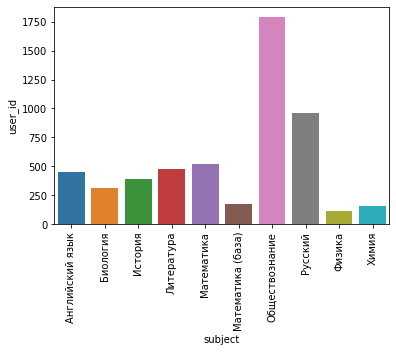

In [172]:
sns.barplot(data=df_result.groupby('subject', as_index=False).agg({'user_id': 'count'}), x='subject', y='user_id')
plt.xticks(rotation=90)

Наиболее популярные предметы: обществознание, русский язык и математика.

In [173]:
# сколько предметов выбрал каждый из учащихся
df_courses = df_result.groupby(['user_id', 'city'], as_index=False)\
             .agg({'subject': 'count'})\
             .rename(columns={'subject': 'summ'})\
             .sort_values(by='summ', ascending=False)\
             .drop_duplicates(subset='user_id')
df_courses

,user_id,city,summ
353,10516,Калуга,5
1224,25942,Краснодар,5
143,10225,Белгород,5
1536,28484,Донецк,5
205,10320,Когалым,5
...,...,...,...
1419,28281,Самара,1
1417,28278,Краснодар,1
1415,28274,Самара,1
1414,28273,Новороссийск,1


In [212]:
# среднее количество выбранных учениками предметов
df_courses.summ.mean().round(2)

1.67

In [209]:
df_courses.groupby('summ').agg({'user_id': 'count'})

,user_id
summ,
1,1586
2,924
3,408
4,76
5,13


Большинство учеников выбирают по 1 предмету, 13 учеников выбрало наибольшее количество предметов (5).

In [175]:
df_city = df_courses.groupby(['city'], as_index=False)\
         .agg({'user_id': 'nunique'})\
         .rename(columns={'user_id': 'students'})\
         .sort_values(by='students', ascending=False)

In [176]:
df_city

,city,students
303,Москва,374
423,Санкт-Петербург,115
232,Краснодар,63
178,Казань,60
339,Новосибирск,52
...,...,...
285,Мелеуз,1
102,Вязьма,1
413,Рузаевка,1
284,Междуреченск,1


Наибольшее количество учеников из Москвы, Санкт-Петербурга, Краснодара, Казани и Новосибирска.

Поделим учеников на группы:

0 группа – присоединились на курс до даты старта курса включительно

1 группа - присоединились на курс в течение 1 недели после даты старта курса включительно

2 группа - присоединились на курс в течение от 1 до 2 недель включительно после даты старта курса

3 группа - присоединились на курс в течение от 2 до 3 недель включительно после даты старта курса

4 группа - присоединились на курс в течение от 3 до 4 недель включительно после даты старта курса

5 группа - присоединились на курс от 4 недель после даты старта курса

In [177]:
def vl_users(x):
    if x < 0:
        return 0
    elif x <= 7:
        return 1
    elif x <= 14:
        return 2
    elif x <= 21:
        return 3
    elif x <= 28:
        return 4
    else:
        return 5


df_result['course_start'] = pd.to_datetime(df_result['course_start'], format='%Y-%m-%d')
df_result['created_at'] = pd.to_datetime(df_result['created_at'], format='%Y-%m-%d %H:%M:%S')
df_result['delta_day'] = (df_result['created_at'] - df_result['course_start']).dt.days   
df_result['group'] = df_result['delta_day'].apply(lambda x: vl_users(x))

In [178]:
df_result

,course_id,course_name,subject,subject_type,course_type,course_start,user_id,last_name,city,active,created_at,full_month,hwork_done,delta_day,group
0,18,Годовой 2к25 стандарт,История,ЕГЭ,Годовой,2024-09-18,10012,Вахрушева,Ижевск,1,2024-07-26 09:14:30,3.0,19.0,-54,0
1,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,10032,Тайгозина,Йошкар-Ола,1,2024-09-21 09:00:48,2.0,13.0,5,1
2,25,Годовой 2к25 стандарт,Биология,ЕГЭ,Годовой,2024-09-17,10033,Боровинская,Екатеринбург,1,2024-07-26 14:08:17,2.0,32.0,-53,0
3,18,Годовой 2к25 стандарт,История,ЕГЭ,Годовой,2024-09-18,10042,Полунина,Курган,1,2024-07-26 16:39:14,2.0,10.0,-54,0
5,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,10069,Рогова,Тольятти,1,2024-07-27 08:56:19,2.0,12.0,-56,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,24,В погоне за пятеркой 2К25 стандарт,Математика (база),ЕГЭ,Годовой,2024-09-17,30676,Сафронова,Москва,1,2024-10-02 20:01:31,2.0,NaN,15,3
5876,16,Годовой 2к25 стандарт,Обществознание,ЕГЭ,Годовой,2024-09-16,30898,Евсефриенкова,Руза,1,2024-10-03 16:53:46,1.0,NaN,17,3
5878,19,Годовой 2к25 стандарт,Русский,ЕГЭ,Годовой,2024-09-21,33437,Vilos,None,1,2024-10-10 20:00:45,1.0,NaN,19,3
5879,98,Погоня за мечтой 2к25,Обществознание,ЕГЭ,Годовой 2.0,2024-11-13,30899,Башинская,Новороссийск,1,2024-10-29 18:47:13,1.0,NaN,-15,0


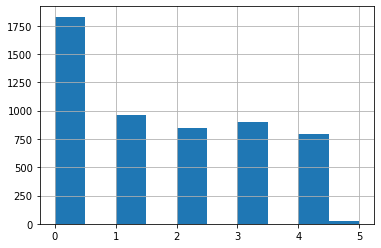

In [205]:
df_result.group.hist()

Чаще всего ученики приоединялись к курcy до его начала.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

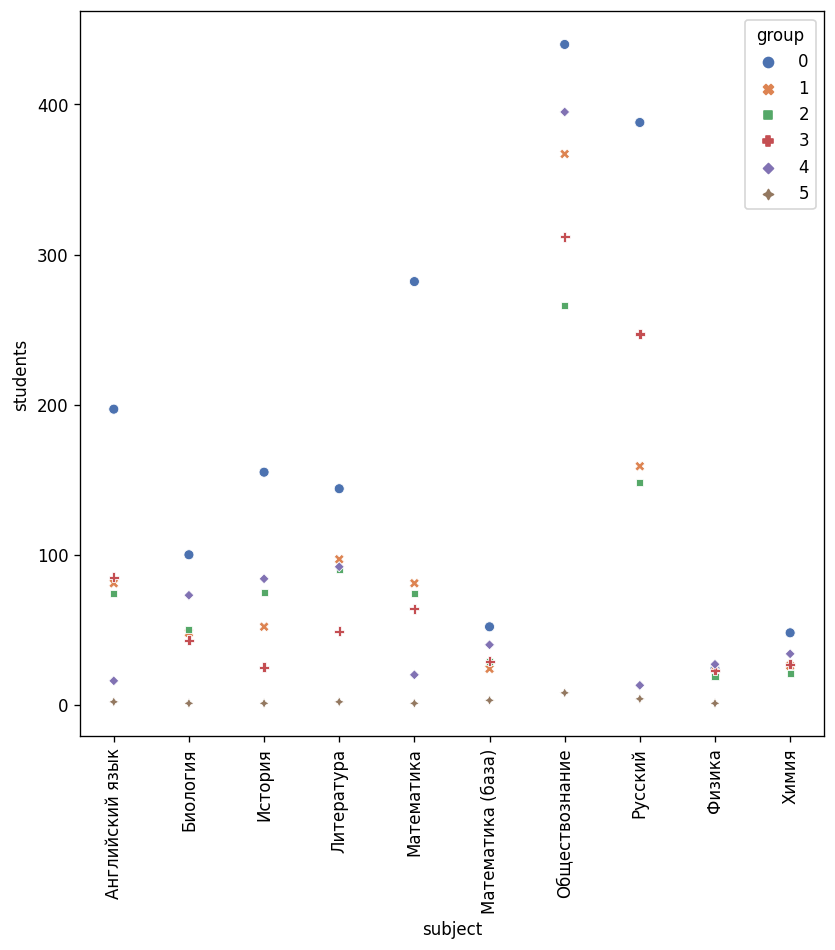

In [208]:
plt.figure(figsize=(8,8), dpi=120)
sns.scatterplot(data=df_result.groupby(['group', 'subject'], as_index=False)\
                .agg({'user_id': 'count'})\
                .rename(columns={'user_id': 'students'}), 
                x='subject', y='students', 
                hue='group', palette='deep', style="group")
plt.xticks(rotation=90)

В целом данный график повторяет предыдущий - большее количество учащихся присоединяются к курсу вначале.
Следует заметить, что отсутствуют ученики, которые присоединились к курсу по химии через 4 недели после даты старта.